In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import mutagenesis_functions as mf
import time as time

In [2]:
# load hairpin data
data_path = '../data_peter/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}



In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    
    layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                        # concat, embedding, variational_normal, variational_softmax, + more
              'num_units': 196,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.5,           # if removed, default is no dropout
             }
    
    layer3 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../results/toyhairpin'
param_path = os.path.join(save_path, 'fullyconnected')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [4]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: dense_0
(?, 196)
layer3: dense_0_batch
(?, 196)
layer4: dense_0_active
(?, 196)
layer5: dense_0_dropout
(?, 196)
layer6: dense_1
(?, 1)
layer7: dense_1_bias
(?, 1)
layer8: output
(?, 1)
----------------------------------------------------------------------------


In [5]:
# initialize session
sess = utils.initialize_session()

In [11]:
#Train the model

# fit model
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=10, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=4.45s -- loss=0.11626 -- acc=95.39740
 
  valid loss:		0.00348
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
  lower cross-validation found
  saving model to:  ../results/toyhairpin/fullyconnected_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=4.65s -- loss=0.00613 -- acc=99.95521
 
  valid loss:		0.00255
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
  lower cross-validation found
  saving model to:  ../results/toyhairpin/fullyconnected_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=4.81s -- loss=0.00520 -- acc=99.94896
 
  valid loss:		0.00262
  valid accuracy:	1.00000+/-0.00000
  valid auc-roc:	1.00000+/-0.00000
  valid auc-pr:		1.00000+/-0.00000
Epoch 4 out of 100 
[==============================] 100.0% -- elapse

In [6]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt
  test  loss:		0.00256
  test  accuracy:	0.99998+/-0.00000
  test  auc-roc:	1.00000+/-0.00000
  test  auc-pr:		1.00000+/-0.00000


In [20]:
#Get Predictions

# calculate activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
predictionslogits = nntrainer.get_activations(sess, test, layer='dense_1_bias')

## Run a First Order Mutagenesis analysis

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt


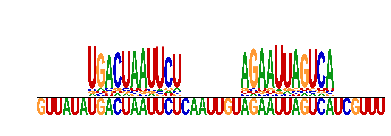

In [54]:
# sort activations
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

X_mut = mf.mutate(X, X.shape[1], X.shape[3])
mutations = {'inputs': X_mut, 'targets': Y_test[:X_mut.shape[0]]}

# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

#Get output activations for the mutations
mut_predictionslogits = nntrainer.get_activations(sess, mutations, layer='dense_1_bias')
mut_predictionsoutput= nntrainer.get_activations(sess, mutations, layer='output')

#shape the predictions of the mutations into the shape of a heatmap
heat_mut = mut_predictionslogits.reshape(X.shape[1],4).T

#normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
norm_heat_mut = heat_mut - predictionslogits[plot_index[0]]
norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

plt.figure(figsize=(15,2))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        norm_heat_mut, 
                                        alphabet='rna', 
                                        nt_width=400)

## Look at the highest predicted sequences

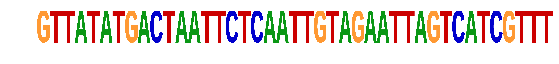

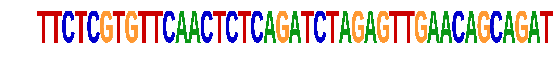

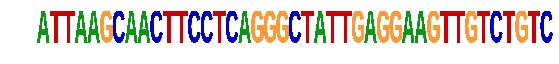

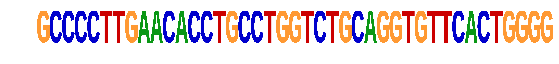

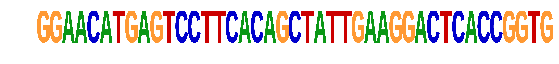

In [71]:
num_plots = 5
for index in plot_index[:num_plots]:

    X = np.expand_dims(test['inputs'][index], axis=0)
    
    plt.figure(figsize=(15,1))
    visualize.plot_pos_saliency(np.squeeze(X).T, norm_factor=0, nt_width=400)

# Average the second order mutagenesis scores for 1000 different sequences

Since each mutagenesis produces 41*41*16 = 26896 sequences, getting scores for 1000 is gonna take a long time...

In [45]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_summary = 1000

sum_mut2_predictoutputs = np.zeros((41*41*16, 1))
starttime = time.time()

for ii in range(num_summary):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get output activations for the mutations
    mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')
    
    #Sum all the scores into a single matrix
    sum_mut2_predictoutputs += mut2_predictoutputs
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()
    


loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt
0
Epoch duration =0.21s
Cumulative duration =0.21s

1
Epoch duration =0.2s
Cumulative duration =0.41s

2
Epoch duration =0.19s
Cumulative duration =0.6s

3
Epoch duration =0.19s
Cumulative duration =0.79s

4
Epoch duration =0.2s
Cumulative duration =0.99s

5
Epoch duration =0.19s
Cumulative duration =1.18s

6
Epoch duration =0.21s
Cumulative duration =1.39s

7
Epoch duration =0.27s
Cumulative duration =1.66s

8
Epoch duration =0.2s
Cumulative duration =1.85s

9
Epoch duration =0.19s
Cumulative duration =2.05s

10
Epoch duration =0.26s
Cumulative duration =2.31s

11
Epoch duration =0.22s
Cumulative duration =2.53s

12
Epoch duration =0.19s
Cumulative duration =2.72s

13
Epoch duration =0.19s
Cumulative duration =2.92s

14
Epoch duration =0.19s
Cumulative duration =3.1s

15
Epoch duration =0.19s
Cumulative duration =3.3s

16
Epoch duration =0.19s
Cumulative duration =3.49s

17
Epoch duration =0.2s
Cumulative duration =3.

In [46]:
# Save the summed array for future use
npy_save_path = 'Arrays/toyhairpin_FC_sumoutputs1000.npy'
np.save(npy_save_path, sum_mut2_predictoutputs)

In [23]:
#Load the saved data
sum_mut2_predictoutputs = np.load('Arrays/toyhairpin_FC_sumoutputs1000.npy')

In [25]:
#average the values
num_summary = 1000
mean_mut2_predictoutputs = sum_mut2_predictoutputs/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_predictoutputs_hol = mean_mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

## Signatures

### First 20

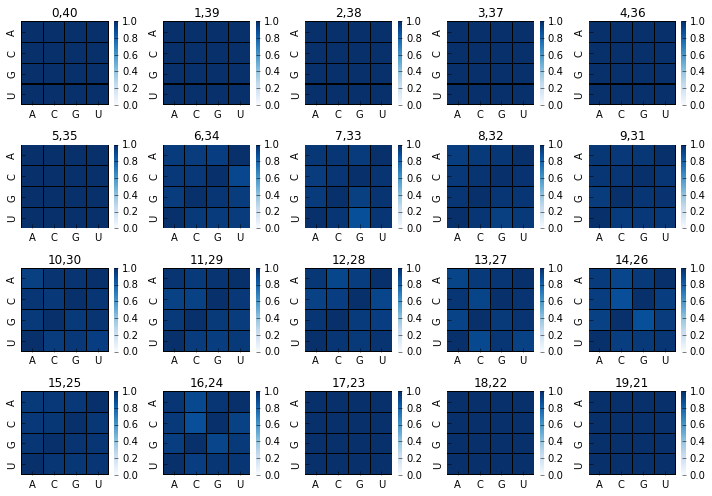

In [26]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(10,7))

num = 20

for ii in range(num):
    ax = fig4.add_subplot(4,5,ii+1)
    ax.set_title(str(ii)+','+str(40-ii))
    ax = sb.heatmap(mean_mut2_predictoutputs_hol[ii, 40-ii], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)



### All bases Paired (editted visuals)

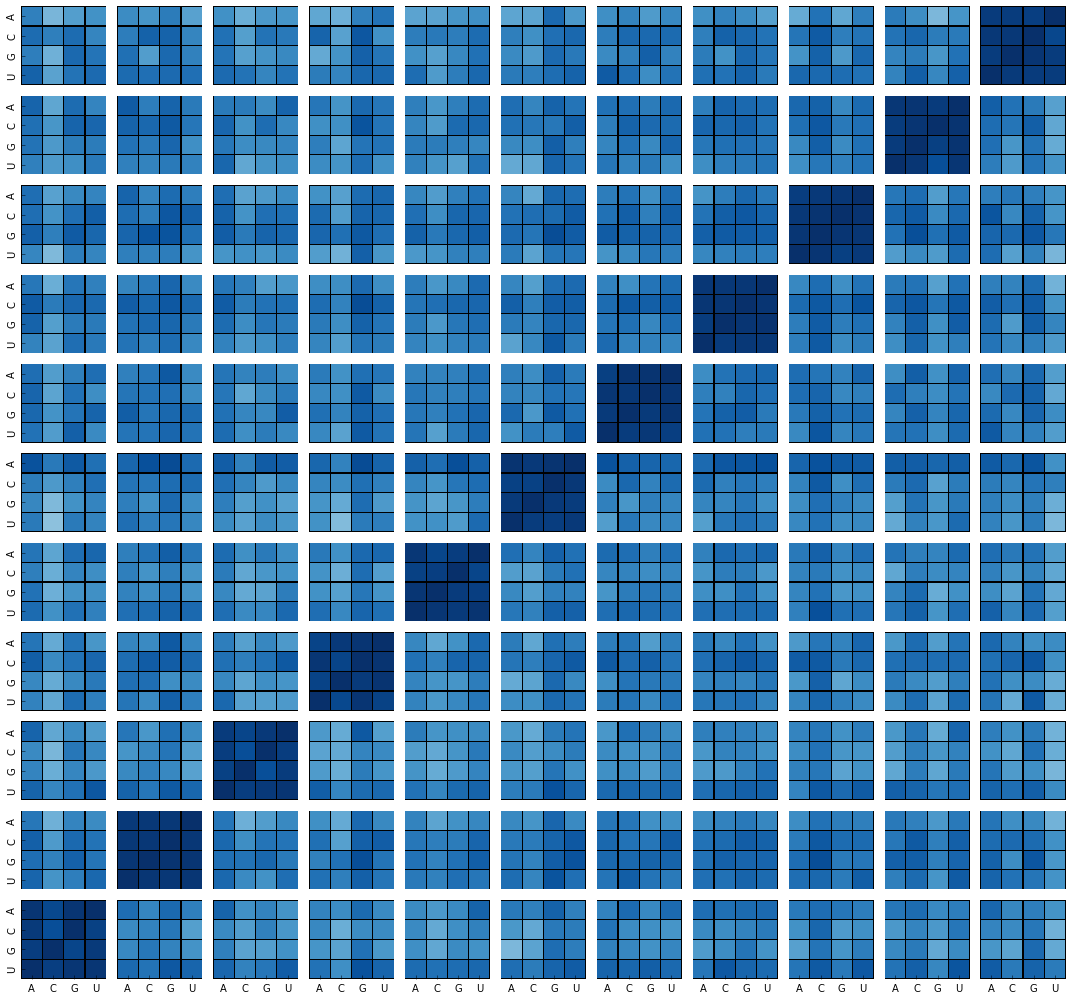

In [27]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,14))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        
        #plot the 0th column with row labels and the num_th most row with column labels
        if two == 0:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc, cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=nuc, cbar=False)
        else:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=[], cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=[], cbar=False)




## Test averages of larger amounts of the data

In [59]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_summary = 3000

sum_mut2_predictoutputs = np.zeros((41*41*16, 1))
starttime = time.time()

for ii in range(num_summary):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get output activations for the mutations
    mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')
    
    #Sum all the scores into a single matrix
    sum_mut2_predictoutputs += mut2_predictoutputs
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()

# Save the summed array for future use
npy_save_path = 'Arrays/toyhairpin_FC_sumoutputs3000.npy'
np.save(npy_save_path, sum_mut2_predictoutputs)
    
#average the values
mean_mut2_predictoutputs = sum_mut2_predictoutputs/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_predictoutputs_hol = mean_mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt
0
Epoch duration =0.2s
Cumulative duration =0.2s

1
Epoch duration =0.19s
Cumulative duration =0.39s

2
Epoch duration =0.19s
Cumulative duration =0.58s

3
Epoch duration =0.19s
Cumulative duration =0.77s

4
Epoch duration =0.26s
Cumulative duration =1.03s

5
Epoch duration =0.24s
Cumulative duration =1.27s

6
Epoch duration =0.19s
Cumulative duration =1.46s

7
Epoch duration =0.19s
Cumulative duration =1.65s

8
Epoch duration =0.19s
Cumulative duration =1.84s

9
Epoch duration =0.2s
Cumulative duration =2.04s

10
Epoch duration =0.19s
Cumulative duration =2.23s

11
Epoch duration =0.2s
Cumulative duration =2.43s

12
Epoch duration =0.21s
Cumulative duration =2.64s

13
Epoch duration =0.2s
Cumulative duration =2.84s

14
Epoch duration =0.2s
Cumulative duration =3.04s

15
Epoch duration =0.19s
Cumulative duration =3.23s

16
Epoch duration =0.2s
Cumulative duration =3.43s

17
Epoch duration =0.19s
Cumulative duration =3.

In [32]:
#Load the saved data
sum_mut2_predictoutputs = np.load('Arrays/toyhairpin_FC_sumoutputs3000.npy')

num_summary = 3000
#average the values
mean_mut2_predictoutputs = sum_mut2_predictoutputs/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_predictoutputs_hol = mean_mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

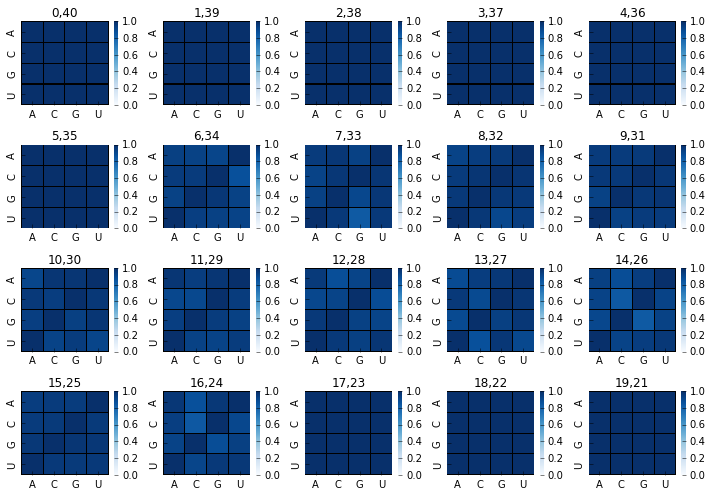

In [33]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(10,7))

num = 20

for ii in range(num):
    ax = fig4.add_subplot(4,5,ii+1)
    ax.set_title(str(ii)+','+str(40-ii))
    ax = sb.heatmap(mean_mut2_predictoutputs_hol[ii, 40-ii], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)



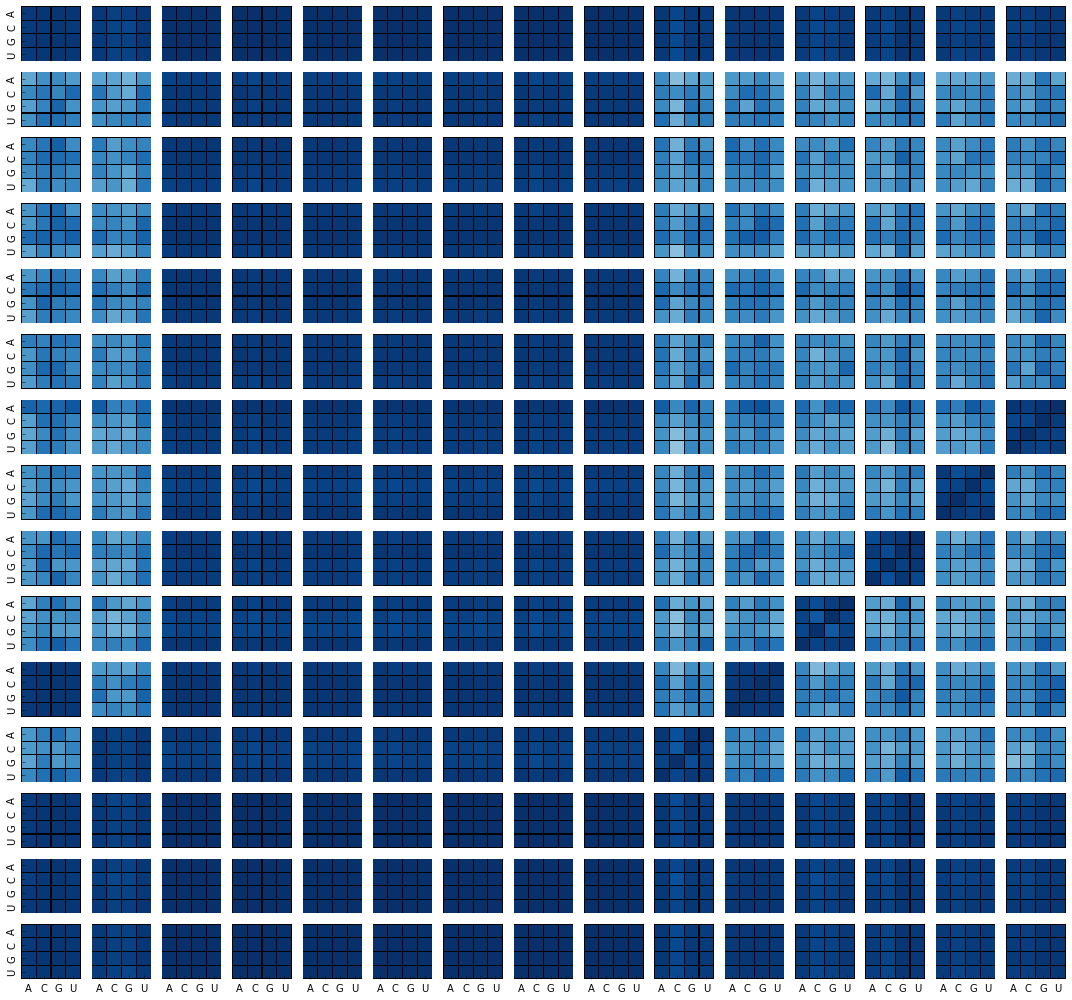

In [34]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,14))

num = 20

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        
        #plot the 0th column with row labels and the num_th most row with column labels
        if two == 0:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+5, two+15], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc, cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+5, two+15], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=nuc, cbar=False)
        else:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+5, two+15], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=[], cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+5, two+15], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=[], cbar=False)




## What is the model learning and how - Look at hidden layers

### The final Dense layer parameters

These give us an idea of the most important neurons for the model. In the final layer, the higher weights correspond to neurons the model wants to highlight in the output.

In [84]:
# plot first layer filters
W = nnmodel.get_parameters(sess, layer='dense_1')[0]
W.shape
top_neurons=np.argsort(np.squeeze(W))[::-1]
top_neurons

array([172, 154,  83,  51,  41,  74, 128,  12,  65,  76, 132,  47, 177,
        89,  35, 138,  75, 135,  27, 136, 173,   3, 183,  46, 143, 163,
       114,  57,   9,  30,   5,  19, 193, 131, 120,  90, 103,   8,  10,
       100, 137, 139, 109, 181,   2, 104,  42, 124, 180,  79,  54, 129,
       112, 105,   6, 192, 151, 178,  82,  97,  52, 117, 126, 158,  31,
        61, 191,  80,  18,  48, 152,  29, 175,  49, 149, 161, 155, 179,
       190, 108,  45,  66,  78, 189,  96, 127, 159, 106, 113,  98, 118,
        17, 147,  94, 170, 148,  85, 166,  36, 144,  58, 194,  20, 115,
        37,  86, 121,  64, 168,  70,  72, 160,  55, 101, 156,  21, 133,
       174, 167, 169,  28,  40,  13, 153,  11,  23,  63,  43, 119, 141,
        93, 107,  62, 184, 125,  22,  91,  32,  81, 102, 150, 165, 186,
        88,  16, 130,  14,  69, 171,  73, 195,  87,  95,  34,  68, 176,
       110,  15,  56,  39, 111,  26,  71,  99,   1,  60,  50, 116,  33,
       146, 134,  67,  25, 162,  38, 182,  53, 188,  44,   0, 18

### The Dense activation layer

The value of each neurons scoring of each sequence

In [41]:
dense = nntrainer.get_activations(sess, test, layer='dense_0_active')
dense.shape

(60000, 196)

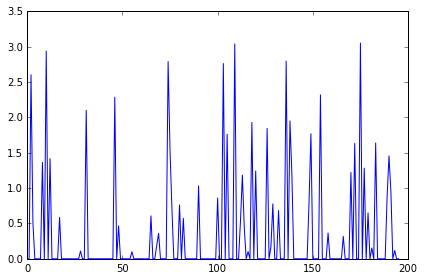

In [130]:
#plot which neurons got activated by the highest predicted sequence (from the outputs)
plt.plot(range(dense.shape[1]), dense[plot_index[0]])
plt.show()

''' An example of how a single sequence can excite various different neurons'''

top_neurons = np.argsort(dense[plot_index[0]])[::-1]

### For a given neuron, evaluate the saliency of its highest scored sequences

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt


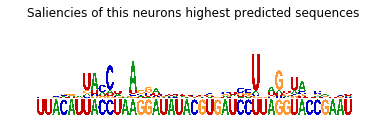

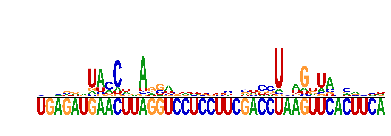

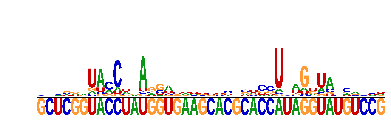

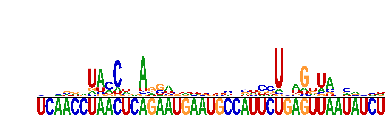

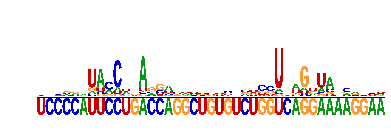

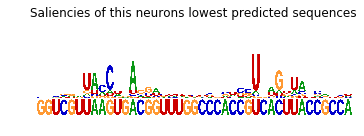

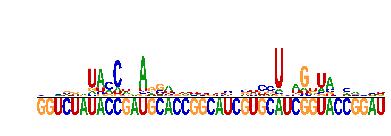

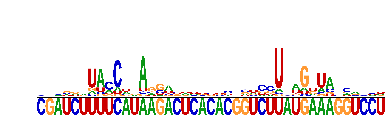

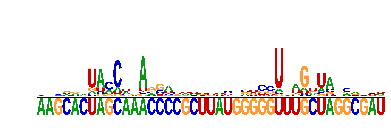

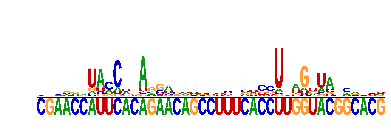

In [93]:
neuron = top_neurons[0]

# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

#sort
top_indices = np.argsort(dense[:,neuron])[::-1]

num_plots=5

plotrange = range(0,num_plots) + range(dense.shape[1]-num_plots, dense.shape[1])

for ii in plotrange:

    X = np.expand_dims(test['inputs'][top_indices[ii]], axis=0)

    X_mut = mf.mutate(X, X.shape[1], X.shape[3])
    mutations = {'inputs': X_mut, 'targets': Y_test[:X_mut.shape[0]]}

    #Get output activations for the mutations
    mut_predictions = nntrainer.get_activations(sess, mutations, layer='dense_0_active')[:,neuron]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictions.reshape(X.shape[1],4).T

    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - dense[top_indices[ii], neuron]
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    plt.figure(figsize=(15,2))
    if ii == 0:
        plt.title('Saliencies of this neurons highest predicted sequences')
    if ii == dense.shape[1]-num_plots:
        plt.title('Saliencies of this neurons lowest predicted sequences')
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                            norm_heat_mut, 
                                            alphabet='rna', 
                                            nt_width=400)

This suggests that a single neuron is looking for the same pattern no matter what the sequence.

### Evaluate what the most import neurons are learning - show the saliency of each neurons highest scored sequence

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt


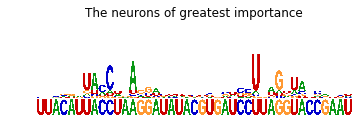

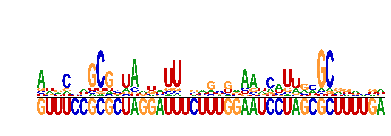

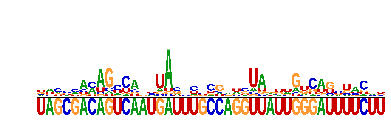

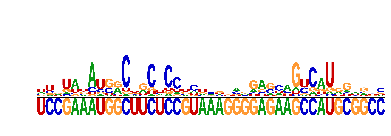

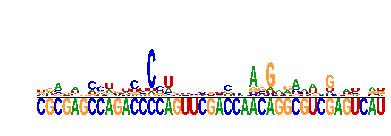

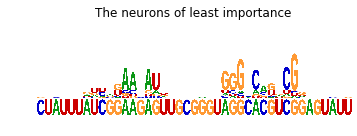

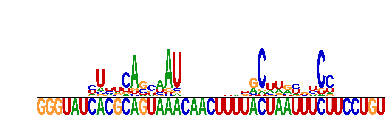

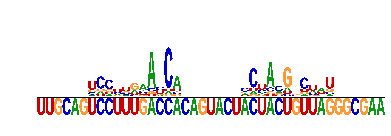

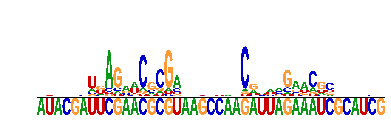

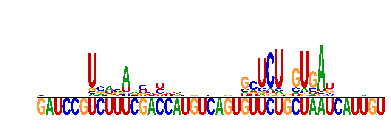

In [111]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_plots = 5
plotrange = np.concatenate((top_neurons[0:num_plots],top_neurons[-num_plots:]))

for neuron in plotrange:

    top_indices = np.argsort(dense[:,neuron])[::-1]

    ii=0

    X = np.expand_dims(test['inputs'][top_indices[ii]], axis=0)

    X_mut = mf.mutate(X, X.shape[1], X.shape[3])
    mutations = {'inputs': X_mut, 'targets': Y_test[:X_mut.shape[0]]}

    #Get output activations for the mutations
    mut_predictions = nntrainer.get_activations(sess, mutations, layer='dense_0_active')[:,neuron]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictions.reshape(X.shape[1],4).T

    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - dense[top_indices[ii], neuron]
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    plt.figure(figsize=(15,2))
    if neuron == plotrange[0]:
        plt.title('The neurons of greatest importance')
    if neuron == plotrange[num_plots]:
        plt.title('The neurons of least importance')
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                            norm_heat_mut, 
                                            alphabet='rna', 
                                            nt_width=400)

### Repeat the above test but plot the saliencies from the same sequence

Doesn't matter much because the saliencies identify the same patterns in any sequence

In [ ]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_plots = 10

ii=0

X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)

X_mut = mf.mutate(X, X.shape[1], X.shape[3])
mutations = {'inputs': X_mut, 'targets': Y_test[:X_mut.shape[0]]}

#Get output activations for the mutations
mut_predictions = nntrainer.get_activations(sess, mutations, layer='dense_0_active')

for neuron in top_neurons[:num_plots]:

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictions[:,neuron].reshape(X.shape[1],4).T

    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - dense[plot_index[ii], neuron]
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    plt.figure(figsize=(15,2))
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                            norm_heat_mut, 
                                            alphabet='rna', 
                                            nt_width=400)

## Perform Second Order Mutagenesis but based on a neurons output

In [124]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_summary = 1000

sum_mut2_scores = np.zeros((41*41*16, dense.shape[1]))
starttime = time.time()

for ii in range(num_summary):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get the neuron's scores for the mutations
    mut2_scores= nntrainer.get_activations(sess, mutations, layer='dense_0_active')
    
    #Sum all the scores into a single matrix
    sum_mut2_scores += mut2_scores
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()

# Save the summed array for future use
npy_save_path = 'Arrays/toyhairpin_FC_sumneuronscores1000.npy'
np.save(npy_save_path, sum_mut2_scores)

#average the values
mean_mut2_scores = sum_mut2_scores/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_scores_hol = mean_mut2_scores.reshape(X.shape[1],X.shape[1],4,4,dense.shape[1])

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt
0
Epoch duration =0.18s
Cumulative duration =0.18s

1
Epoch duration =0.18s
Cumulative duration =0.36s

2
Epoch duration =0.15s
Cumulative duration =0.51s

3
Epoch duration =0.18s
Cumulative duration =0.7s

4
Epoch duration =0.16s
Cumulative duration =0.86s

5
Epoch duration =0.17s
Cumulative duration =1.03s

6
Epoch duration =0.15s
Cumulative duration =1.17s

7
Epoch duration =0.15s
Cumulative duration =1.32s

8
Epoch duration =0.17s
Cumulative duration =1.49s

9
Epoch duration =0.14s
Cumulative duration =1.63s

10
Epoch duration =0.14s
Cumulative duration =1.77s

11
Epoch duration =0.15s
Cumulative duration =1.92s

12
Epoch duration =0.15s
Cumulative duration =2.06s

13
Epoch duration =0.15s
Cumulative duration =2.21s

14
Epoch duration =0.14s
Cumulative duration =2.36s

15
Epoch duration =0.14s
Cumulative duration =2.5s

16
Epoch duration =0.15s
Cumulative duration =2.64s

17
Epoch duration =0.15s
Cumulative duratio

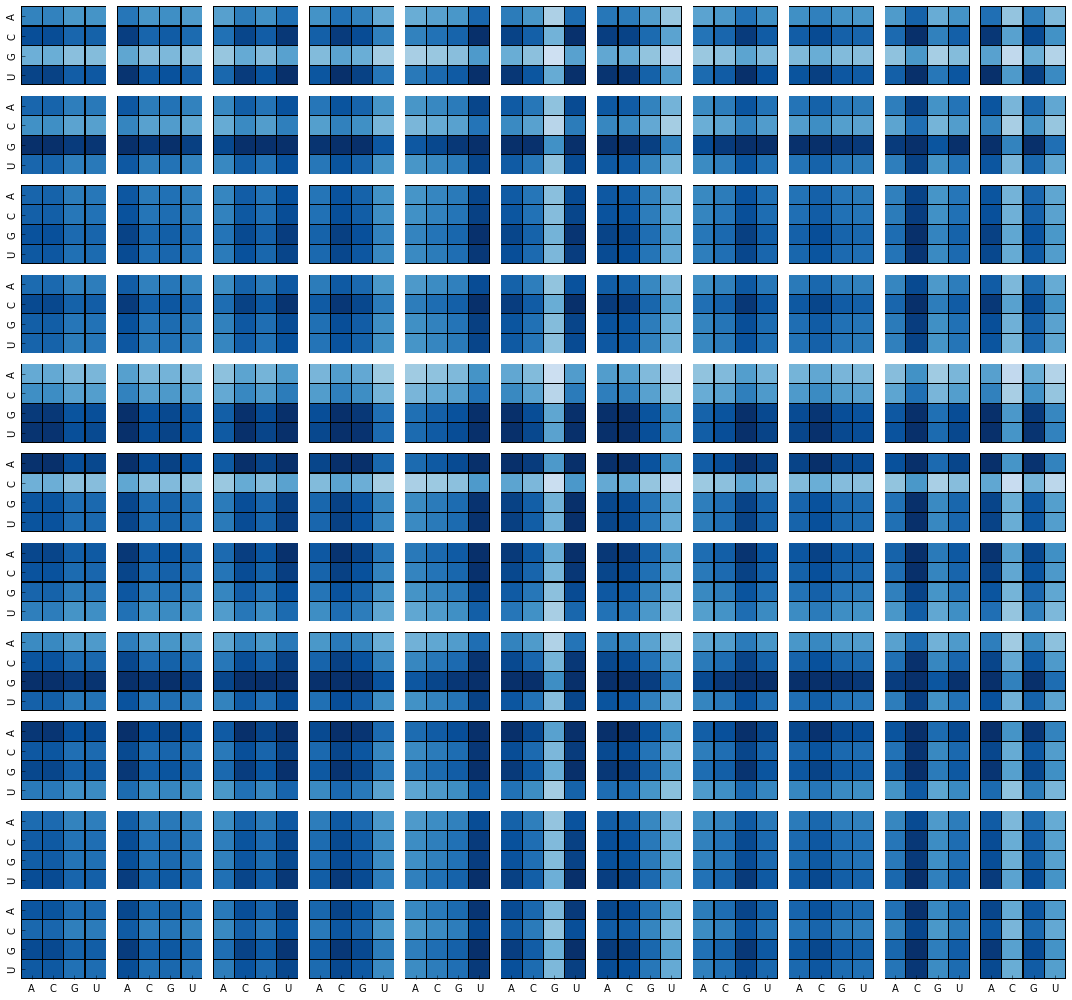

In [131]:
#select neuron
neuron = top_neurons[0]
#select mutation information for that neuron
mean_mut2_predictoutputs_hol = mean_mut2_scores_hol[:, :, :, :, neuron]


nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,14))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        
        #plot the 0th column with row labels and the num_th most row with column labels
        if two == 0:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc, cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=nuc, cbar=False)
        else:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=[], cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=[], cbar=False)




In [138]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

#select neuron
neuron = top_neurons[0]
#sort
top_indices = np.argsort(dense[:,neuron])[::-1]

num_summary = 1000

sum_mut2_scores = np.zeros((41*41*16,))
starttime = time.time()


for ii in range(num_summary):
    print (ii)
    epoch_starttime = time.time()
    
    X = np.expand_dims(test['inputs'][top_indices[ii]], axis=0)
    
    #mutate the sequence
    X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

    #reshape the 6D tensor into a 4D tensor that the model can test
    X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
    
    mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}
    
    #Get the neuron's scores for the mutations
    mut2_scores= nntrainer.get_activations(sess, mutations, layer='dense_0_active')[:,neuron]
    
    #Sum all the scores into a single matrix
    sum_mut2_scores += mut2_scores
    
    epoch_endtime = time.time()
    
    print ('Epoch duration =' + str(np.around((epoch_endtime -epoch_starttime), 2)) + 's')
    print ('Cumulative duration =' + str(np.around((epoch_endtime - starttime), 2)) + 's')
    print ()

#average the values
mean_mut2_scores = sum_mut2_scores/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
mean_mut2_scores_hol = mean_mut2_scores.reshape(X.shape[1],X.shape[1],4,4)

loading model from:  ../results/toyhairpin/fullyconnected_best.ckpt
0
Epoch duration =0.15s
Cumulative duration =0.15s

1
Epoch duration =0.13s
Cumulative duration =0.29s

2
Epoch duration =0.14s
Cumulative duration =0.43s

3
Epoch duration =0.14s
Cumulative duration =0.57s

4
Epoch duration =0.14s
Cumulative duration =0.7s

5
Epoch duration =0.13s
Cumulative duration =0.84s

6
Epoch duration =0.14s
Cumulative duration =0.98s

7
Epoch duration =0.16s
Cumulative duration =1.15s

8
Epoch duration =0.14s
Cumulative duration =1.28s

9
Epoch duration =0.13s
Cumulative duration =1.42s

10
Epoch duration =0.14s
Cumulative duration =1.56s

11
Epoch duration =0.14s
Cumulative duration =1.7s

12
Epoch duration =0.14s
Cumulative duration =1.84s

13
Epoch duration =0.14s
Cumulative duration =1.98s

14
Epoch duration =0.14s
Cumulative duration =2.12s

15
Epoch duration =0.14s
Cumulative duration =2.26s

16
Epoch duration =0.14s
Cumulative duration =2.4s

17
Epoch duration =0.14s
Cumulative duration

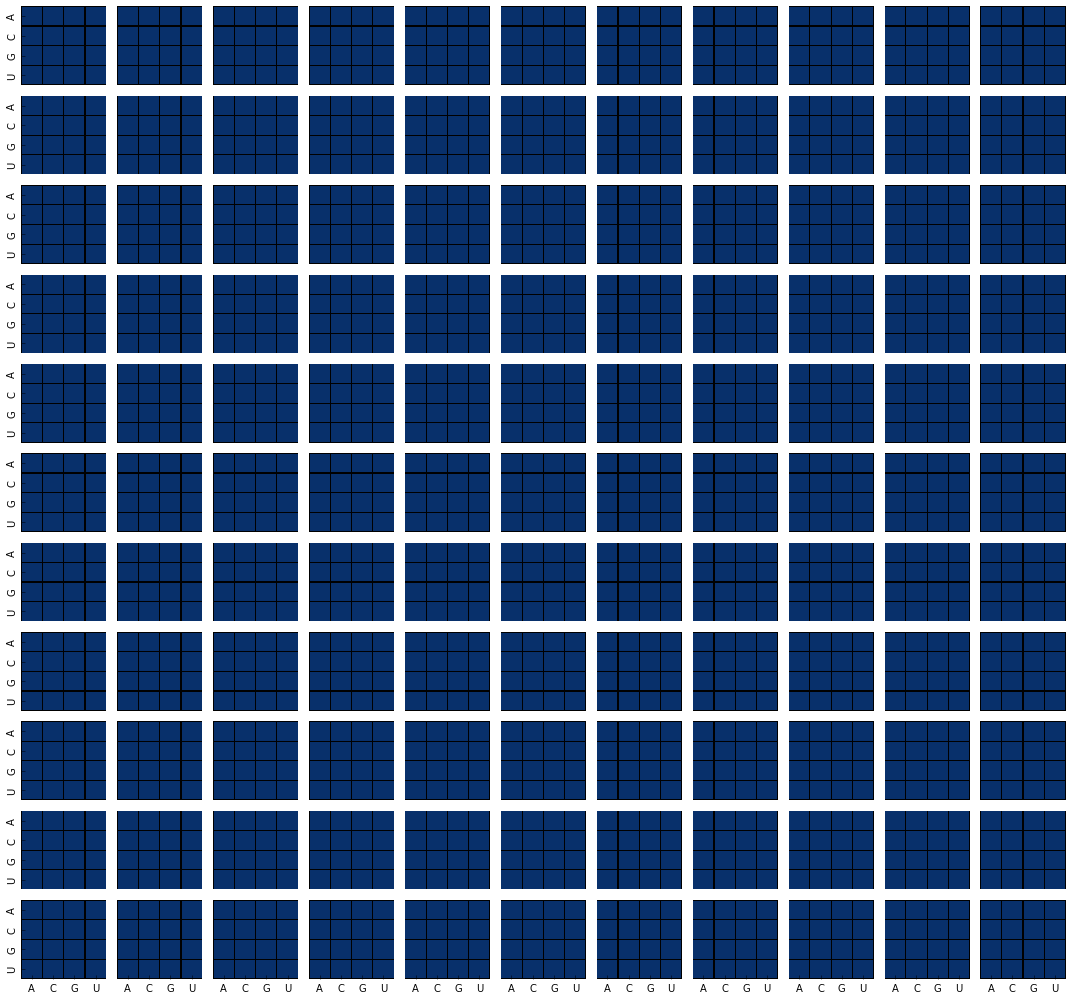

In [139]:
#select neuron
neuron = top_neurons[0]
#select mutation information for that neuron
mean_mut2_predictoutputs_hol = mean_mut2_scores_hol


nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,14))

num = 11

for one in range(num):
    for two in range(num):
        ax = fig4.add_subplot(num, num, ((one*num)+two)+1)
        
        #plot the 0th column with row labels and the num_th most row with column labels
        if two == 0:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc, cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=nuc, cbar=False)
        else:
            if one == (num-1):
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=[], cbar=False)
            else:
                ax = sb.heatmap(mean_mut2_predictoutputs_hol[one+6, two+24], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=[], yticklabels=[], cbar=False)


